### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [228]:
import pandas as pd

Наши новости

In [229]:
news = pd.read_csv("../Lection2/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [230]:
users = pd.read_csv("../Lection2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [231]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [232]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [233]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [234]:

stopword_ru = stopwords.words('/Users/vladv/nltk_data/stopwords.txt')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [235]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

1250

In [236]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [237]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 36.4 s


In [238]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 41s


А теперь в 3 строчки обучим нашу модель

In [239]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [240]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

Что такое common_dictionary и как он выглядит

In [241]:
common_dictionary[16]

'генеральный'

Все просто - это словарь наших слов

Запускаем обучение

In [242]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 39.6 s


In [243]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [244]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.23748222),
 (2, 0.08215879),
 (4, 0.044168055),
 (14, 0.19127634),
 (20, 0.42367083)]

In [245]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия российский nn сша новый правительство исследование
topic_1: запуск технология агентство земля использование сша миссия
topic_2: снижение мозг товар конкурс значительно теория супруг
topic_3: газ военный район риск американский россия станция
topic_4: восток эксперимент тип пилот дальний питание поток
topic_5: испытание сенатор вклад компьютерный израиль перевод негативно
topic_6: украина новый область продукция обращение киев кровь
topic_7: обнаружить выяснить земля экипаж найти след запустить
topic_8: лаборатория расследование мышь акционер парка клиент индустрия
topic_9: километр параметр устойчивый датчик пить высота актёр
topic_10: россия nn российский путин украина министр владимир
topic_11: nn исследование день университет первый жизнь всё
topic_12: научный наука москва nn журнал военный территория
topic_13: фонд рак берег лекарство вдвое армения риск
topic_14: изучение мальчик саммит дональд правовой мэй терминал
topic_15: млрд банк объём млн высота место рейтинг

In [246]:
x

[(0,
  [('россия', 0.010690608),
   ('российский', 0.008447846),
   ('nn', 0.0064318804),
   ('сша', 0.0062716403),
   ('новый', 0.0054761837),
   ('правительство', 0.0049202126),
   ('исследование', 0.0048562754)]),
 (1,
  [('запуск', 0.018911986),
   ('технология', 0.018642582),
   ('агентство', 0.014947539),
   ('земля', 0.014434456),
   ('использование', 0.012955763),
   ('сша', 0.011024906),
   ('миссия', 0.009026014)]),
 (2,
  [('снижение', 0.036584817),
   ('мозг', 0.02184217),
   ('товар', 0.019246047),
   ('конкурс', 0.015414828),
   ('значительно', 0.013053146),
   ('теория', 0.009872314),
   ('супруг', 0.009367979)]),
 (3,
  [('газ', 0.015287413),
   ('военный', 0.0120477015),
   ('район', 0.010924141),
   ('риск', 0.009771034),
   ('американский', 0.009523779),
   ('россия', 0.0084917545),
   ('станция', 0.007780393)]),
 (4,
  [('восток', 0.04602581),
   ('эксперимент', 0.041168146),
   ('тип', 0.023004107),
   ('пилот', 0.020327194),
   ('дальний', 0.019882832),
   ('питан

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [247]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [248]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.397625,0.000000,0.026341,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.287376,0.0,0.0,0.0,0.0
1,4896,0.623917,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,4897,0.237493,0.000000,0.082001,0.0,0.044168,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.423775,0.0,0.0,0.0,0.0
3,4898,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.919895,0.0,0.0,0.0,0.0
4,4899,0.000000,0.108459,0.000000,0.0,0.000000,0.0,0.735301,0.0,0.0,...,0.03071,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [249]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [250]:
users['articles'] = users['articles'].apply(lambda x: "".join([i.strip() for i in x.replace("[","").replace("]","")]), 1)

In [251]:
users.head(3)

,uid,articles
0,u105138,"293672,293328,293001,293622,293126,1852"
1,u108690,"3405,1739,2972,1158,1599,322665"
2,u108339,"1845,2009,2356,1424,2939,323389"


In [295]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
tfidf = tfidf.fit(users['articles'])
feature_names = [int(i) for i in tfidf.get_feature_names()]

In [296]:
idf = pd.DataFrame({'articles_id' : feature_names, 'idf' : tfidf.idf_})

In [297]:
idf_dict = dict(zip(idf['articles_id'].values, idf['idf'].values))

In [298]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [299]:
#idf_dict

In [311]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_tf_idf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id]*idf_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [313]:
get_user_embedding_tf_idf(user_articles_list)

array([3.91137775, 0.23966622, 0.02391152, 0.23839315, 0.05836836,
       0.        , 0.        , 0.02986129, 0.01614781, 0.        ,
       1.02659871, 0.31265256, 1.21083196, 0.        , 0.12596012,
       0.        , 0.18258816, 0.18972539, 0.        , 0.03625633,
       0.25168525, 0.        , 0.        , 0.1075006 , 0.        ])

In [334]:
user_embeddings_idf = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_tf_idf(x), 1)])
user_embeddings_idf.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_idf['uid'] = users['uid'].values
user_embeddings_idf = user_embeddings_idf[['uid']+['topic_{}'.format(i) for i in range(25)]]

KeyError: 7

In [ ]:
#doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
#doc_dict[293622]

In [336]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [337]:
get_user_embedding(user_articles_list)

array([0.48920847, 0.02885325, 0.00257274, 0.02564974, 0.00666851,
       0.        , 0.        , 0.0032129 , 0.00207286, 0.        ,
       0.12981971, 0.03897789, 0.14770045, 0.        , 0.01616926,
       0.        , 0.02308939, 0.02398   , 0.        , 0.00465416,
       0.0290541 , 0.        , 0.        , 0.01375059, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [338]:
users['articles'].iloc[33]

'323329,321961,324743,323186,324632,474690'

In [339]:
#" ".join(news[news['doc_id']==474690]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [340]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.246333,0.074817,0.000000,0.090128,0.004560,0.011823,0.112438,0.007859,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.088440,0.010864
1,u108690,0.416560,0.008546,0.012978,0.048474,0.004305,0.000000,0.091701,0.000000,0.002676,...,0.007180,0.014478,0.027285,0.004639,0.000000,0.076431,0.0,0.0,0.023899,0.010433
2,u108339,0.356575,0.014354,0.000000,0.141255,0.010962,0.005710,0.022040,0.015145,0.001931,...,0.007497,0.024128,0.011197,0.014635,0.005118,0.056494,0.0,0.0,0.034415,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [341]:
target = pd.read_csv("../Lection2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [342]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.246333,0.074817,0.000000,0.090128,0.004560,0.011823,0.112438,0.007859,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.088440,0.010864,0
1,u108690,0.416560,0.008546,0.012978,0.048474,0.004305,0.000000,0.091701,0.000000,0.002676,...,0.014478,0.027285,0.004639,0.000000,0.076431,0.0,0.0,0.023899,0.010433,1
2,u108339,0.356575,0.014354,0.000000,0.141255,0.010962,0.005710,0.022040,0.015145,0.001931,...,0.024128,0.011197,0.014635,0.005118,0.056494,0.0,0.0,0.034415,0.000000,1


In [343]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [344]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [345]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [346]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10505425, 0.05684934, 0.30723811, 0.2143289 , 0.09892038,
       0.24647438, 0.09897729, 0.12123644, 0.15128243, 0.16039705])

In [347]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [348]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.244037, F-Score=0.549, Precision=0.487, Recall=0.629


При медиане get_user_embedding=  Best Threshold=0.276666, F-Score=0.736, Precision=0.717, Recall=0.755

При среднем np.mean get_user_embedding =  Best Threshold=0.224513, F-Score=0.637, Precision=0.545, Recall=0.767

При среднем np.max get_user_embedding = Best Threshold=0.347336, F-Score=0.802, Precision=0.812, Recall=0.792

In [349]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1593  162]
 [  92  153]]


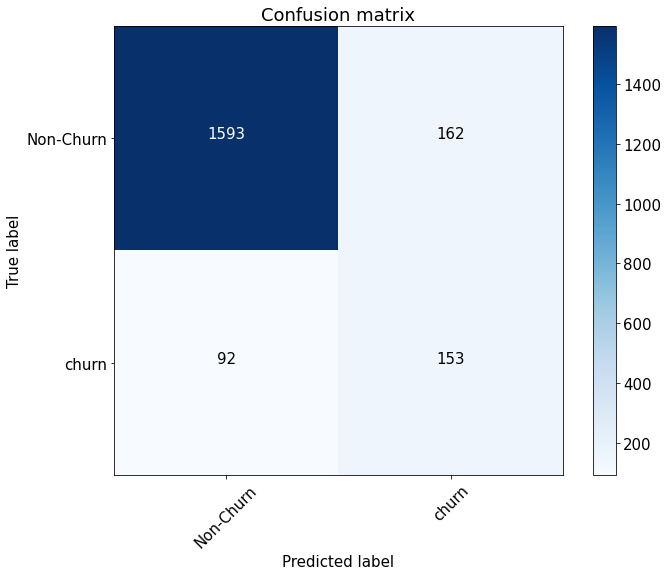

In [350]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [351]:
roc_auc_score(y_test, preds)

0.8906145706145706

In [388]:
table_metrics = pd.DataFrame(np.array([[0.9311076225361941, 0.224513, 0.637, 0.545, 0.767], [0.9622792022792023, 0.276666, 0.736, 0.717, 0.755], [0.976926565497994, 0.347336, 0.802, 0.812, 0.792]]),
                   columns=['roc_auc_score', 'Best Threshold', 'F-Score', 'Precision', 'Recall'])
table_metrics.rename(index={0: 'mean', 1: 'median', 2: 'max'})

,roc_auc_score,Best Threshold,F-Score,Precision,Recall
mean,0.931108,0.224513,0.637,0.545,0.767
median,0.962279,0.276666,0.736,0.717,0.755
max,0.976927,0.347336,0.802,0.812,0.792


При среднем np.mean get_user_embedding = Best Threshold=0.224513, F-Score=0.637, Precision=0.545, Recall=0.767

При медиане get_user_embedding= Best Threshold=0.276666, F-Score=0.736, Precision=0.717, Recall=0.755

При среднем np.max get_user_embedding = Best Threshold=0.347336, F-Score=0.802, Precision=0.812, Recall=0.792

Roc_ auc При значении get_user_embedding np.mean = 0.9311076225361941

Roc_ auc При значении get_user_embedding np.median = 0.9622792022792023

Roc_ auc При значении get_user_embedding np.max = 0.976926565497994

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk